In [1]:
import numpy as np
import pandas as pd
import sqlite3

from sklearn.model_selection import train_test_split

In [2]:
# Connect to the database
DB_PATH = '../resources/capstone_db.sqlite'
db = sqlite3.connect(DB_PATH)

# Get a cursor
cursor = db.cursor()

In this notebook, we will prepare the datasets that will be used to train, tune and test the models and store them in a NPZ file.  
We will also make a PCA analysis and define the precision of the baseline models.

## 1. Load the data from the database

In [3]:
query = '''
SELECT
    ts.kepoi_name,
    ts.fpflag_bitstring,
    kois.koi_disposition,   
    sp.feh,
    sp.ebminusv,
    ts.teff_sqrt,
    ts.radius_log10,    
    ts.teff_maxthresh,
    ts.radius_maxthresh, 
    ts.ebminusv_maxthresh,
    ts.feh_minthresh,
    ts.tperiod_log10, 
    ts.tdepth_log10, 
    ts.tdur_log10,
    ts.indur_log10, 
    ts.indur_tdur_ratio_log10, 
    ts.tdur_tperiod_ratio_log10,
    tp.impact,
    ts.indur_tdur_ratio_maxthresh, 
    ts.tdur_tperiod_ratio_minthresh,
    ts.tdur_tperiod_ratio_maxthresh, 
    ts.tdepth_minthresh, 
    ts.tdepth_maxthresh,
    ts.location_cluster_fpco
FROM
         tce_status AS ts
    JOIN stellar_properties AS sp ON (ts.kepid = sp.kepid)
    JOIN transit_parameters AS tp ON (ts.kepoi_name = tp.kepoi_name)
    JOIN kois_activity_table AS kois ON (ts.kepoi_name = kois.kepoi_name)
WHERE
    ts.excluded = 0
'''
df = pd.read_sql_query(query, db)
print('Table Shape:', df.shape)
df.head()

Table Shape: (4875, 24)


,kepoi_name,fpflag_bitstring,koi_disposition,feh,ebminusv,teff_sqrt,radius_log10,teff_maxthresh,radius_maxthresh,ebminusv_maxthresh,...,indur_log10,indur_tdur_ratio_log10,tdur_tperiod_ratio_log10,impact,indur_tdur_ratio_maxthresh,tdur_tperiod_ratio_minthresh,tdur_tperiod_ratio_maxthresh,tdepth_minthresh,tdepth_maxthresh,location_cluster_fpco
0,K00752.01,0000,CONFIRMED,0.14,0.142,76.485293,0.017033,0,0,0,...,-0.180874,-0.714746,-0.443304,0.934177,0,0,0,0,0,0
1,K00752.02,0000,CONFIRMED,0.14,0.142,76.485293,0.017033,0,0,0,...,-0.588736,-1.250147,-1.074335,0.711630,0,0,0,0,0,0
2,K00755.01,0000,CONFIRMED,0.07,0.142,77.659513,0.019532,0,0,0,...,-1.153577,-1.364348,-0.191597,0.690533,0,0,0,0,0,0
3,K00114.01,0110,FALSE POSITIVE,0.00,0.104,78.911343,0.291813,0,0,0,...,0.396806,-0.301030,-0.169148,0.999941,1,0,0,0,0,1
4,K00010.01,0000,CONFIRMED,-0.04,0.096,78.898669,0.161667,0,0,0,...,-0.278841,-0.793530,-0.032162,0.706142,0,0,0,0,0,0


In [4]:
# Counts
df.koi_disposition.value_counts()

FALSE POSITIVE    2288
CONFIRMED         1610
CANDIDATE          977
Name: koi_disposition, dtype: int64

## 2. Prepare the candidate dataset

In [5]:
filter = df.koi_disposition == 'CANDIDATE'

# Candidates features
candidates = df[filter].iloc[:, 3:].values

# Candidates KOI identifier
candidate_ids = df.kepoi_name[filter].values

# Feature names
feature_names = list(df.columns)[3:]

## 3. Prepare the training and test datasets

In [6]:
filter = df.koi_disposition != 'CANDIDATE'

# Features to train and test models
features = df[filter].iloc[:, 3:].values

# KOI identifiers
feature_ids = df.loc[filter , ['kepoi_name', 'fpflag_bitstring']].values

# Encoded labels
labels = df.koi_disposition[filter].map({'FALSE POSITIVE': 0, 'CONFIRMED': 1}).values

# Label names
label_names = ['FALSE POSITIVE', 'CONFIRMED']

In [7]:
# Split the train/test sets (3000 training / 898 test stratified split)
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=898, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=labels) 

# Split the IDs the same way than the features
Ids_train, Ids_test, _, _ = train_test_split(feature_ids, 
                                         labels, 
                                         test_size=898, 
                                         random_state=0, 
                                         shuffle=True, 
                                         stratify=labels)

print('Training dataset shape: ', X_train.shape, y_train.shape)
print('Test dataset shape: ', X_test.shape, y_test.shape)

Training dataset shape:  (3000, 21) (3000,)
Test dataset shape:  (898, 21) (898,)


In [8]:
# Training set counts
print('Training dataset counts:')
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
).rename(index={0:'FALSE POSITIVE', 1:'CONFIRMED'})

Training dataset counts:


,count,normalized
FALSE POSITIVE,1761,0.587
CONFIRMED,1239,0.413


In [9]:
# Test set counts
print('Test dataset counts:')
pd.DataFrame({
    'count': pd.value_counts(y_test), 
    'normalized': pd.value_counts(y_test, normalize=True)}
).rename(index={0:'FALSE POSITIVE', 1:'CONFIRMED'})

Test dataset counts:


,count,normalized
FALSE POSITIVE,527,0.58686
CONFIRMED,371,0.41314


## 4. Save the datasets in a NPZ file

In [10]:
# Transit model dataset path
PATH = '../resources/model_datasets.npz'

# Save the features, labels, names and cadidates data in a npz file
np.savez(PATH, 
         X_train=X_train, 
         X_test=X_test,
         y_train=y_train,
         y_test=y_test,
         Ids_train=Ids_train,
         Ids_test=Ids_test,
         candidates=candidates,
         candidate_ids=candidate_ids,
         feature_names=feature_names,
         label_names=label_names
        )

## 5. PCA Analysis

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [12]:
# Function to get the number of components that statisfy a proportion of variance explained
def get_pca_n_components(cumsum, threshold=0.95):
    idx = np.nonzero(cumsum >= threshold)[0][0] # nonzero return a tuple of arrays 
    return idx + 1

# Function that return the cumulative variance for a number of components
def get_cumulative_variance(cumsum, n_components):
    return cumsum[n_components - 1]

In [13]:
# Rescale data
scaler = StandardScaler()
X = scaler.fit_transform(X_train)

In [14]:
# Principal Component Analysis
pca = PCA(n_components=None)
pca.fit(X, y=None)

# Variance explained & Cumulative Sum
pve = pca.explained_variance_ratio_
pve_cumsum = np.cumsum(pve)

# Print the number of components required to explain different proportion of variance
print('Number of components (variance >20%):', get_pca_n_components(pve_cumsum, threshold=0.2))
print('Number of components (variance >50%):', get_pca_n_components(pve_cumsum, threshold=0.5))
print('Number of components (variance >80%):', get_pca_n_components(pve_cumsum, threshold=0.8))
print('Number of components (variance >90%):', get_pca_n_components(pve_cumsum, threshold=0.9))
print('Number of components (variance >95%):', get_pca_n_components(pve_cumsum, threshold=0.95))
print('Number of components (variance >99%):', get_pca_n_components(pve_cumsum, threshold=0.99))

Number of components (variance >20%): 1
Number of components (variance >50%): 4
Number of components (variance >80%): 9
Number of components (variance >90%): 12
Number of components (variance >95%): 15
Number of components (variance >99%): 18


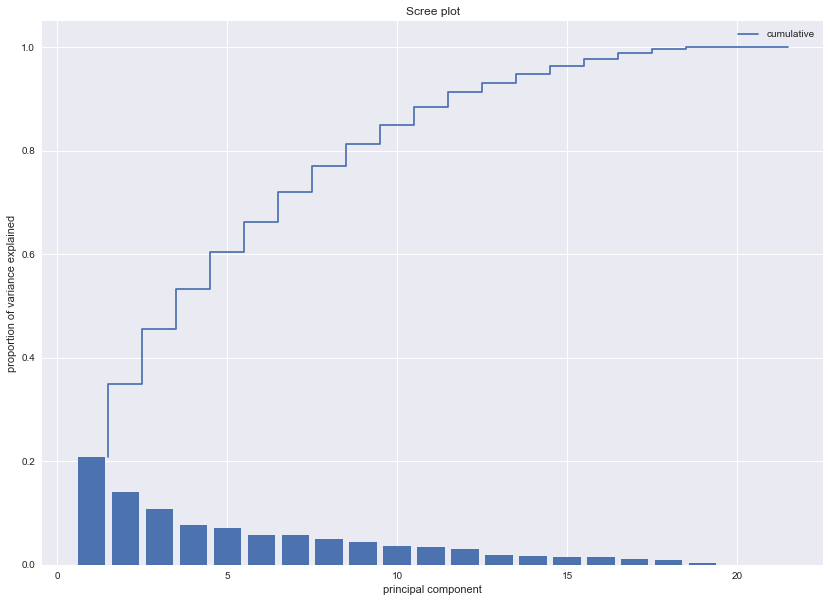

In [15]:
# Scree plot
plt.figure(figsize=(14, 10))
xcor = np.arange(1, pve_cumsum.shape[0] + 1)
plt.bar(xcor, pve)  # bar plot
plt.step(xcor + 0.5, pve_cumsum, label='cumulative')  # cumulative plot

plt.title('Scree plot')
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.show()

## 6. Baseline Models

We know that the training and test set contains 58.7% of false positives and 41.3% of exoplanets, meaning that the baseline precision score if we would always predict an exoplanet outcome is 41.3%.

However, during the EDA, we have been able to engineer indicator variables identifying easely a lot of false positives.  
It would be more realistic to compare our models to a baseline without all these false positives.

In [16]:
# Create a dataframe from the training set
df_train = pd.DataFrame(X_train)
df_train.columns = feature_names

# filter that join all the engineered threshold indicator variables
f = df_train.radius_maxthresh.astype(bool) | \
    df_train.ebminusv_maxthresh.astype(bool) | \
    df_train.feh_minthresh.astype(bool) | \
    df_train.indur_tdur_ratio_maxthresh.astype(bool) | \
    df_train.tdur_tperiod_ratio_minthresh.astype(bool) | \
    df_train.tdur_tperiod_ratio_maxthresh.astype(bool) | \
    df_train.tdepth_minthresh.astype(bool) | \
    df_train.tdepth_maxthresh.astype(bool) 

In [17]:
# Most-frequent baseline model
pd.Series(y_train[~f]).value_counts(normalize=True).rename(index={0:'FALSE POSITIVE', 1:'CONFIRMED'})

CONFIRMED         0.664023
FALSE POSITIVE    0.335977
dtype: float64

Our baseline model has a precision of 66.4%.